<a href="https://colab.research.google.com/github/AISoltani/GAN_Flower_TF_Dataset/blob/main/GAN_flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/NoxMoon/gan_flowers.git

Cloning into 'gan_flowers'...
remote: Enumerating objects: 475, done.
remote: Total 475 (delta 0), reused 0 (delta 0), pack-reused 475
Receiving objects: 100% (475/475), 761.18 MiB | 38.46 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Updating files: 100% (338/338), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp  /content/drive/MyDrive/flower_photos.tgz /content/data/

In [ ]:
import tarfile
data_dir = '/content/data'
tarfile.open("/content/data/flower_photos.tgz", 'r:gz').extractall(data_dir)

In [ ]:
import os

old_name = r"/content/data/flower_photos"
new_name = r"/content/data/jpg"
os.rename(old_name, new_name)

In [ ]:
#%matplotlib inline
data_dir = '/content/data'
%cd /content/gan_flowers
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import glob
import gc
from gan_utils import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/content/gan_flowers
Random Seed:  999


In [ ]:
ngpu = 1
nz = 32
ngf = 128
ndf = 64
nc = 3
lr_decay = 0.9
decay_every = 20
mask_sizes = []
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print('device:', device)

device: cuda:0


In [ ]:
# Load dataset
from os import listdir
from os.path import isfile, join
img_dir = data_dir + '/jpg/'
image_paths = [join(img_dir, f)
             for f in listdir(img_dir) if isfile(join(img_dir, f))]
# image_paths = sorted(glob.glob("content/data/jpg/*.jpg"))
# image_paths = [path for path in image_paths if path.find('1')<0]
realdata = flower_dataset(image_paths, 
                          transform=transforms.Compose(
                              [transforms.ToTensor(),transforms.Resize((64, 64)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

def collate_fn(batch):
   batch = list(filter(lambda x: x is not None, batch))
   return torch.utils.data.dataloader.default_collate(batch)
dataloader = DataLoader(realdata, batch_size=64, shuffle=True,collate_fn=collate_fn, num_workers=4)

100%|██████████| 3669/3669 [00:22<00:00, 163.96it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(realdata)

3669

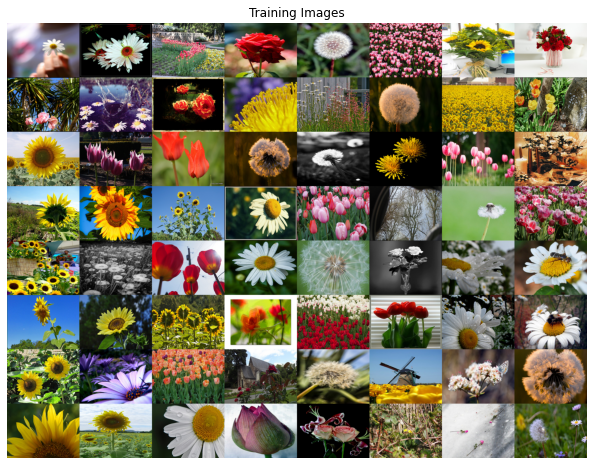

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Create the Generator
netG = Generator(ngpu, ngf, nz, nc).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
print("netG parameters:", [p.numel() for p in netG.parameters() if p.requires_grad])

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(32, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): ReflectionPad2d((-1, -1, -1, -1))
    (2): BatchNorm2d(128,

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu, ndf, nc).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print("netD parameters", [p.numel() for p in netD.parameters() if p.requires_grad])

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d

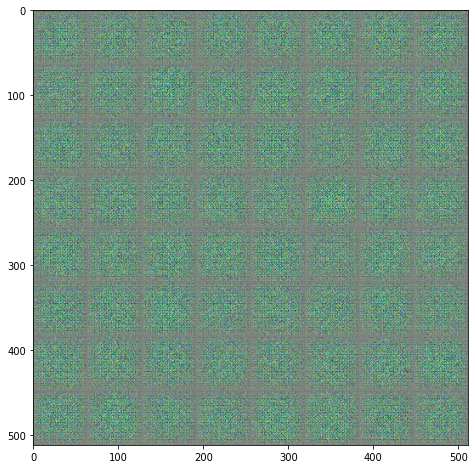

In [ ]:
fixed_noise = torch.randn(64, nz, 2, 2, device=device)
fake_image = netG(fixed_noise)
output = netD(fake_image)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(vutils.make_grid(fake_image.detach(), padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
checkpoint = torch.load("model_checkpoints/Flower_GAN")
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

In [14]:
!mkdir model_checkpoints
!mkdir sample_images
!mkdir sample_images/gan_z22

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 50
start_epoch = 201

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, start_epoch+num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        #real_cpu = data.to(device)
        real_cpu = noise_input(data, noise_level=0.2*np.exp(-epoch*0.01), device=device, clip=False)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        #label = get_label(b_size, real_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label.float())
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 2, 2, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #label = get_label(b_size, fake_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #print("output1",output[:5])
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label.float())
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        #label = get_label(b_size, real_label, soft=0.2, noise=False, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label.float())
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 128 == 0:
            print('[%d/%d][%d/%d]  Loss_D: %.4f (%.4f / %.4f)  Loss_G: %.4f  D(x): %.4f  D(G(z)): %.4f / %.4f'
                  % (epoch, start_epoch+num_epochs, i, len(dataloader),
                     errD.item(), errD_real.item(), errD_fake.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            Ggradnorm_first = list(netG.parameters())[0].grad.norm()
            Ggradnorm_last = list(netG.parameters())[-1].grad.norm()
            print("Ggradnorm first: %.4f\t Ggradnormlast: %.4f"%(Ggradnorm_first, Ggradnorm_last))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == start_epoch+num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            image_tensor = vutils.make_grid(fake, padding=2, normalize=True)
            img_list.append(image_tensor)
            filepath = 'sample_images/gan_z22/ep'+str(epoch)+'_itr'+str(i)+'.jpg'
            io.imsave(filepath, image_tensor.numpy().transpose(1,2,0))

        iters += 1
        
    if epoch%20==0:
        checkpoint_path = "model_checkpoints/GAN_z22_ep"+str(epoch)
        print('save model to %s'%checkpoint_path)
        torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, checkpoint_path)
        
    if epoch%decay_every==0:
        adjust_learning_rate(optimizerD, lr_decay)
        adjust_learning_rate(optimizerG, lr_decay)
        
print('Done')

mkdir: cannot create directory ‘model_checkpoints’: File exists
mkdir: cannot create directory ‘sample_images’: File exists
mkdir: cannot create directory ‘sample_images/gan_z22’: File exists
Starting Training Loop...


[201/251][0/58]  Loss_D: 0.3230 (0.3151 / 0.0078)  Loss_G: 6.3588  D(x): 0.7643  D(G(z)): 0.0078 / 0.0032
Ggradnorm first: 17.1716	 Ggradnormlast: 30.6258
[202/251][0/58]  Loss_D: 0.5713 (0.5711 / 0.0002)  Loss_G: 14.3971  D(x): 0.7267  D(G(z)): 0.0002 / 0.0000
Ggradnorm first: 2.7338	 Ggradnormlast: 29.4833
[203/251][0/58]  Loss_D: 0.6249 (0.4511 / 0.1738)  Loss_G: 4.9236  D(x): 0.7975  D(G(z)): 0.1551 / 0.0103
Ggradnorm first: 4.8007	 Ggradnormlast: 20.9202
[204/251][0/58]  Loss_D: 1.0720 (0.6541 / 0.4180)  Loss_G: 2.3084  D(x): 0.5914  D(G(z)): 0.3278 / 0.1116
Ggradnorm first: 2.5046	 Ggradnormlast: 16.7490
[205/251][0/58]  Loss_D: 0.8373 (0.6932 / 0.1441)  Loss_G: 2.7737  D(x): 0.5740  D(G(z)): 0.1283 / 0.0938
Ggradnorm first: 2.0847	 Ggradnormlast: 16.8170
[206/251][0/58]  Loss_D: 0.6339 (0.1927 / 0.4412)  Loss_G: 4.3267  D(x): 0.8555  D(G(z)): 0.2983 / 0.0257
Ggradnorm first: 2.2730	 Ggradnormlast: 14.6739
[207/251][0/58]  Loss_D: 0.5956 (0.1628 / 0.4328)  Loss_G: 4.6181  D(x): 0

[210/251][0/58]  Loss_D: 0.7269 (0.4715 / 0.2554)  Loss_G: 2.5862  D(x): 0.6547  D(G(z)): 0.2123 / 0.0986
Ggradnorm first: 3.1286	 Ggradnormlast: 14.5910
[211/251][0/58]  Loss_D: 0.7605 (0.7119 / 0.0486)  Loss_G: 4.4885  D(x): 0.5567  D(G(z)): 0.0445 / 0.0218
Ggradnorm first: 2.8987	 Ggradnormlast: 13.0227
[212/251][0/58]  Loss_D: 0.8980 (0.5086 / 0.3894)  Loss_G: 1.7218  D(x): 0.6480  D(G(z)): 0.2936 / 0.2267
Ggradnorm first: 3.1943	 Ggradnormlast: 7.5816
[213/251][0/58]  Loss_D: 0.8239 (0.1482 / 0.6757)  Loss_G: 4.9919  D(x): 0.8827  D(G(z)): 0.4441 / 0.0165
Ggradnorm first: 3.9105	 Ggradnormlast: 8.8091
[214/251][0/58]  Loss_D: 0.6235 (0.2206 / 0.4029)  Loss_G: 3.3831  D(x): 0.8296  D(G(z)): 0.2914 / 0.0434
Ggradnorm first: 3.5066	 Ggradnormlast: 12.4205
[215/251][0/58]  Loss_D: 0.9071 (0.1904 / 0.7167)  Loss_G: 2.6282  D(x): 0.8449  D(G(z)): 0.4708 / 0.0973
Ggradnorm first: 3.6576	 Ggradnormlast: 10.2371
[216/251][0/58]  Loss_D: 0.9846 (0.4379 / 0.5467)  Loss_G: 2.2146  D(x): 0.698

[219/251][0/58]  Loss_D: 1.3605 (0.1179 / 1.2426)  Loss_G: 3.4621  D(x): 0.8970  D(G(z)): 0.6080 / 0.0535
Ggradnorm first: 6.0652	 Ggradnormlast: 14.3486
[220/251][0/58]  Loss_D: 1.4035 (0.3009 / 1.1026)  Loss_G: 3.9878  D(x): 0.7708  D(G(z)): 0.6104 / 0.0377
Ggradnorm first: 5.0040	 Ggradnormlast: 9.7263
save model to model_checkpoints/GAN_z22_ep220
[221/251][0/58]  Loss_D: 2.0376 (0.1187 / 1.9189)  Loss_G: 3.3626  D(x): 0.8953  D(G(z)): 0.8025 / 0.0492
Ggradnorm first: 4.0483	 Ggradnormlast: 9.8976
[222/251][0/58]  Loss_D: 1.5618 (0.0836 / 1.4782)  Loss_G: 3.7504  D(x): 0.9239  D(G(z)): 0.7221 / 0.0429
Ggradnorm first: 4.8613	 Ggradnormlast: 7.5749
[223/251][0/58]  Loss_D: 0.8769 (0.4770 / 0.3999)  Loss_G: 2.3954  D(x): 0.6588  D(G(z)): 0.2877 / 0.1343
Ggradnorm first: 4.9080	 Ggradnormlast: 14.1922
[224/251][0/58]  Loss_D: 0.8098 (0.2727 / 0.5372)  Loss_G: 2.7445  D(x): 0.7830  D(G(z)): 0.3723 / 0.0879
Ggradnorm first: 3.7333	 Ggradnormlast: 7.8221
[225/251][0/58]  Loss_D: 0.8084 (0

[227/251][0/58]  Loss_D: 0.8949 (0.4351 / 0.4598)  Loss_G: 3.0932  D(x): 0.6803  D(G(z)): 0.3290 / 0.0732
Ggradnorm first: 4.0204	 Ggradnormlast: 12.5804
[228/251][0/58]  Loss_D: 0.7468 (0.1153 / 0.6315)  Loss_G: 4.4083  D(x): 0.8961  D(G(z)): 0.4328 / 0.0203
Ggradnorm first: 3.7753	 Ggradnormlast: 9.6780
[229/251][0/58]  Loss_D: 0.6981 (0.2472 / 0.4509)  Loss_G: 3.4983  D(x): 0.8001  D(G(z)): 0.3189 / 0.0459
Ggradnorm first: 4.5432	 Ggradnormlast: 8.1024
[230/251][0/58]  Loss_D: 1.0509 (0.7155 / 0.3354)  Loss_G: 2.0472  D(x): 0.5549  D(G(z)): 0.2560 / 0.1605
Ggradnorm first: 4.1480	 Ggradnormlast: 8.0987
[231/251][0/58]  Loss_D: 1.1324 (0.1033 / 1.0291)  Loss_G: 4.5085  D(x): 0.9062  D(G(z)): 0.6007 / 0.0183
Ggradnorm first: 4.3993	 Ggradnormlast: 8.3900
[232/251][0/58]  Loss_D: 1.1178 (0.1743 / 0.9434)  Loss_G: 3.9381  D(x): 0.8501  D(G(z)): 0.5611 / 0.0291
Ggradnorm first: 4.6143	 Ggradnormlast: 7.4109
[233/251][0/58]  Loss_D: 0.6058 (0.1318 / 0.4740)  Loss_G: 3.0892  D(x): 0.8817  

[236/251][0/58]  Loss_D: 0.8986 (0.3355 / 0.5631)  Loss_G: 3.5607  D(x): 0.7577  D(G(z)): 0.3954 / 0.0406
Ggradnorm first: 4.2313	 Ggradnormlast: 9.1664
[237/251][0/58]  Loss_D: 1.5000 (0.0769 / 1.4231)  Loss_G: 4.0268  D(x): 0.9304  D(G(z)): 0.6941 / 0.0285
Ggradnorm first: 4.1208	 Ggradnormlast: 8.0257
[238/251][0/58]  Loss_D: 1.8113 (0.0908 / 1.7205)  Loss_G: 3.6754  D(x): 0.9185  D(G(z)): 0.7555 / 0.0388
Ggradnorm first: 4.4172	 Ggradnormlast: 10.2384
[239/251][0/58]  Loss_D: 0.9865 (0.1636 / 0.8229)  Loss_G: 3.8460  D(x): 0.8577  D(G(z)): 0.5218 / 0.0303
Ggradnorm first: 4.8062	 Ggradnormlast: 10.6998
[240/251][0/58]  Loss_D: 0.8854 (0.5786 / 0.3067)  Loss_G: 2.1112  D(x): 0.6145  D(G(z)): 0.2371 / 0.1617
Ggradnorm first: 3.5176	 Ggradnormlast: 8.3581
save model to model_checkpoints/GAN_z22_ep240
[241/251][0/58]  Loss_D: 0.9152 (0.7076 / 0.2076)  Loss_G: 2.0952  D(x): 0.5372  D(G(z)): 0.1706 / 0.1695
Ggradnorm first: 3.5130	 Ggradnormlast: 9.3837
[242/251][0/58]  Loss_D: 0.9509 (0

[245/251][0/58]  Loss_D: 0.8785 (0.4611 / 0.4174)  Loss_G: 2.6008  D(x): 0.6558  D(G(z)): 0.3105 / 0.0992
Ggradnorm first: 4.0315	 Ggradnormlast: 9.3123
[246/251][0/58]  Loss_D: 0.7548 (0.4545 / 0.3004)  Loss_G: 1.9946  D(x): 0.6730  D(G(z)): 0.2396 / 0.1669
Ggradnorm first: 3.9353	 Ggradnormlast: 6.6392
[247/251][0/58]  Loss_D: 2.1092 (0.0681 / 2.0411)  Loss_G: 4.4303  D(x): 0.9366  D(G(z)): 0.8357 / 0.0188
Ggradnorm first: 4.7899	 Ggradnormlast: 8.4253
[248/251][0/58]  Loss_D: 0.5469 (0.2609 / 0.2860)  Loss_G: 3.4686  D(x): 0.7987  D(G(z)): 0.2285 / 0.0438
Ggradnorm first: 4.4119	 Ggradnormlast: 7.7983
[249/251][0/58]  Loss_D: 0.7240 (0.4880 / 0.2360)  Loss_G: 2.0541  D(x): 0.6551  D(G(z)): 0.1952 / 0.1618
Ggradnorm first: 3.9116	 Ggradnormlast: 7.4796
[250/251][0/58]  Loss_D: 1.2227 (0.8343 / 0.3883)  Loss_G: 1.0840  D(x): 0.4959  D(G(z)): 0.2706 / 0.4083
Ggradnorm first: 2.9340	 Ggradnormlast: 4.7044


Done


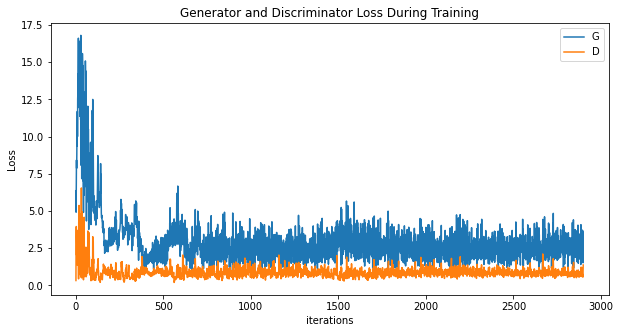

In [15]:
# plot losses during training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[gif @ 0x55f3724dd7c0] GIF muxer supports only a single video GIF stream.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument
Error initializing output stream 0:0 -- 



CalledProcessError: ignored

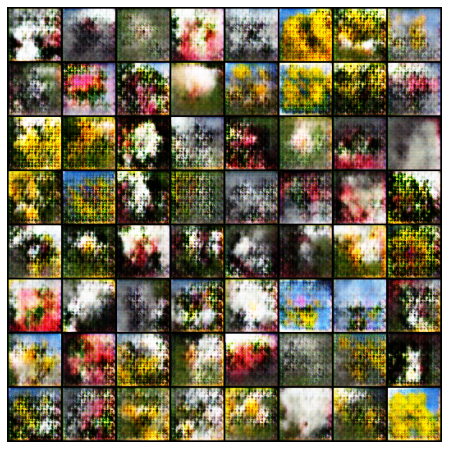

In [19]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save("gan_nomask.gif")
HTML(ani.to_jshtml())

In [17]:
# save model
torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, "model_checkpoints/Flower_GAN")

In [ ]:
!cp /content/gan_flowers/model_checkpoints/Flower_GAN /content/drive/MyDrive